## Imports

In [1]:
import csv
import json
import numpy as np
import os

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2




import matplotlib.pyplot as plt
import numpy
import pickle


import shelfy.models.similarity

## Levenshtein

In [ ]:
import sys
import Levenshtein

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../models/')
import similarity

In [ ]:
book_info = {}

book_info['title'] = 'Mining the Social Web'
book_info['authors'] = ['Matthew A. Russell']
book_info['publisher'] = "O'Reilly Media; Second Edition edition (October 20, 2013)"

book_words = shelfy.models.similarity.preprocess_book_info(book_info)
print(book_words)

tokens = ['SECOND', 'EDITION', 'Mining', 'the', 'Social', 'Web', 'Russell', 'Russell', 'O', 'O', "'", "'", 'REILLY', 'REILLY']
tokens = shelfy.models.similarity.preprocess_book_tokens(tokens)

print(tokens)

In [ ]:
similarities = np.empty((len(tokens), len(book_words)))

fig = plt.figure(figsize = (8,6))

for i, token in enumerate(tokens):
    for j, book_word in enumerate(book_words):
        
        similarities[i,j] = shelfy.models.similarity.single_token_inverse_weighted_levenshtein_tfidf([token], [book_word])
        
        #print(distance/len(token))
        #similarities[j,i] = distance

print(similarities)
        
plt.imshow(similarities, cmap = 'gray')
plt.colorbar()

plt.ylabel('tokens')
plt.xlabel('book words')

plt.yticks([i for i in range(len(tokens))], [token for token in tokens])
plt.xticks([i for i in range(len(book_words))], [word for word in book_words], rotation = 90)

fig.tight_layout()

plt.savefig('token-matching.png', dpi = 300)

plt.show()
        

## Similarity and right/wrong classification

In [2]:
submission_base_directory = shelfy.SHELFY_BASE_PATH + '/static/submissions/'
submissions = [submission for submission in os.listdir(submission_base_directory)]
submission_directories = [submission_base_directory + submission for submission in submissions]


def get_submission_shelf_name(submission_directory):
    with open(submission_directory + '/info.txt', 'r') as file_handle:
        shelf_name = file_handle.readline().split('.')[0]
    return shelf_name


        

# Loop over all submissions
similarities = []
corrects = []
for i in range(len(submissions)):
    
    
    # Get the book objects out
    books_directory = submission_directories[i] + '/books/'
    book_ids = [id for id in os.listdir(books_directory)]
    
    books = []
    for book_id in book_ids:
        with open(books_directory + book_id, 'rb') as file_handle:
            book = pickle.load(file_handle)
            books.append(book)
            
    # Get the actual list of books that are present in the image out
    shelf_name = get_submission_shelf_name(submission_directories[i])
    shelf_directory = shelfy.SHELFY_BASE_PATH + '/data/shelves/' + shelf_name + '/'
    
    titles_amazon_products = []
    with open(shelf_directory + 'titles_amazon_products', 'r') as file_handle:
        reader = csv.reader(file_handle, delimiter = ',')
        for row in reader:
            titles_amazon_products.append(row[1])
            
    # For each book, calculate similarity and whether match was correct or not
    for book in books:
        
        # Calculate similarity
        similarity = shelfy.models.similarity.calculate_book_score(book)
        
        
        # Determine whether the match was correct or not
        if book.book_info['title'] in titles_amazon_products:
            correct = 1
        else:
            correct = 0
            
        # Append
        similarities.append(similarity)
        corrects.append(correct)
        
similarities = np.array(similarities)
corrects = np.array(corrects)

/home/prestonh/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none
title none


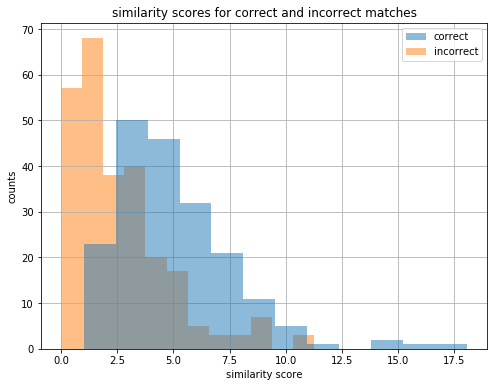

In [12]:
fig = plt.figure(figsize = (8,6))

plt.hist(similarities[corrects == 1], alpha = 0.5, bins = 12, zorder = 2, label = 'correct')
plt.hist(similarities[np.where(corrects == 0)], alpha = 0.5, bins = 12, zorder = 1, label = 'incorrect')


# Cosmetics
plt.title('similarity scores for correct and incorrect matches')
plt.xlabel('similarity score')
plt.ylabel('counts')
plt.grid(zorder = 0)
plt.legend(loc = 'best')


plt.savefig('sim_histo.png', dpi = 300)
plt.show()